# COGS 118A - Final Project

# Multiple Object Tracking

## Group members

- Chao-Li Wei (Michael)
- Andrew Truong
- Zeyu Feng (Ted)
- Ahmad Said
- Chiadika Vincent

# Abstract 
Simultaneous tracking of multiple objects in a real-world environment has been active in the research field, even more so with the emerging popularity in the field of autonomous vehicles. The goal of our project is to perform Multiple Object Tracking (MOT) for the downsampled and subsetted BDD 100K dataset, containing 400 videos with 8 different categories. Then, on a frame-by-frame basis, the model will predict bounding boxes to capture the objects present in the image and classify the corresponding objects. The performance will be measured by a handful of different evaluation metrics including percent accuracy and precision across all 8 categories, checking for false positives and negatives, as well as its F1 score. The main contribution of our work will be performing hyperparameter tuning on the baseline model provided by the competition, performing model selection based on the evaluation metrics, and creating visualization to interpret the model embeddings and model results on the original videos.

# Background
Object tracking has been omnipotent in a variety of applications such as gesture recognizers, face identifiers, pose estimators<a name="pose"></a>[<sup>[1]</sup>](#posenote), and scene analysis tools. However, for certain applications such as autonomous driving, the importance of accuracy of the model becomes especially important as tiny errors from the model can result in severe humanitarian casualties. Thus, the questions become what defines a good metric to evaluate the accuracy of the model, and what approach is plausible to push its performance.

As there has not been agreement on a set of commonly applicable metrics for MOT, we will optimize the primary metrics multiple object tracking precision (MOTP) and the multiple object tracking accuracy (MOTA) proposed by Barnardin, which allow for objective comparison of the main characteristics of tracking systems<a name="mota"></a>[<sup>[2]</sup>](#motanote). We will also use other supplementary metrics to provide a more holistic evaluation of the models.

In addition, some existing methods to perform MOT use appearance features to associate objects across different frames, for example, SiameseCNN learns the similarity between a pair of detected objects with a Siamese Network <a name="siamese"></a>[<sup>[9]</sup>](#siamesenote). In “DEFT: Detection Embeddings for Tracking”, the researchers implement a CenterNet as the object detection module and a Deep Affinity Network as the object matching module <a name="deft"></a>[<sup>[6]</sup>](#deftnote). 

For our work, we will implement the baseline model trained using Quasi-Dense Similarity Learning <a name="quasi"></a>[<sup>[8]</sup>](#quasinote) to perform object tracking. At the high level, the model will use pretrained weights to generate the bounding boxes and perform classification, then use quasi-dense similarity learning to cluster the same object across frames close and different objects far away in the embedding space. More details can be found in the [Proposed Solution](#proposed_solution) below.

# Problem Statement

The problem that we are trying to solve is multiple object tracking (MOT). Multiple object tracking can be summarized as the task of “locating multiple objects, maintaining their identities, and yielding their individual trajectories given an input video.”<a name="mot"></a>[<sup>[3]</sup>](#motnote) For the BBD 100K dataset, our goal is very similar to the classic MOT task. Our goal is to predict 2D bounding boxes for objects and their association across frames in a video sequence of camera images. The camera images are frames from a video that show the view of an autonomous vehicle. The objects that we will be predicting are objects that the autonomous vehicle should detect while driving. The accuracy of our predictions will be based on many evaluation metrics like multiple object tracking accuracy (MOTA) and multiple object tracking precision (MOTP). These will be explained more in depth in our evaluation metrics section, but here’s a quick summary of each one. MOTA measures the errors from false positives, false negatives, and identity (id) switches. On the other hand, MOTP measures the misalignments between ground-truths and detections. 

# Data

To download the dataset, go to https://bdd-data.berkeley.edu/ , register for a free account and download the zip files. More instructions on parsing and installing the dataset can be found in the README file provided by BDD100K at https://github.com/SysCV/bdd100k-models/blob/main/doc/PREPARE_DATASET.md.


Since the dataset provided by BDD100K is extremely large, we will be working on a subset of the training data that contains around 200 videos. Each video is around 40 seconds long and they are annotated at 5 fps (resampled from 30 fps), resulting in approximately 200 frames/images per video and a total of around 40,000 frames/images in the training set, totaling to 80,000 when including validation images. And all the images have 1280x720 pixels. We can convert each frame/image into a 3-dimensional array(x coordinates, y coordinates and RGB values) of numbers that has a shape of 1280x720x3 using the OpenCV package in Python.


The annotations of each image contain information for the objects that should be detected and tracked at each frame. The labels for each object includes:
- `id`: Each object has an unique id, and the same object across different frames keeps the same id. 
This can help us track the same object across different frames
- `Category`: type of the object, “car” or “other vehicles”
- `box2d`: Region Of Interest(bounding boxes) of the object and their positions on the frame indicated by x1, x2, y1, and y2 values. This is another important variable that can help us track the location of the object in the image/frame
- `Attributes`
    - `Occluded`: whether the object is occluded
    - `Truncated`: whether the object is truncated



# Data Size Discussion

The videos are already resampled from 5 Hz to 30 Hz by BDD100K. The original training dataset has over 2000 videos, taking about 56 GB of storage. To make our training more feasible given the compute resources we have, we use only 200 videos for training and 200 videos for validation, each taking about 5.6 GB of storage. 

* CPU: With a 20GB RAM CPU with Intel Core i7 processor, it takes about 32 days to run a single epoch on our training data, 10 days to evaluate the model
* GPU: With 2 GeForce RTX 208 GPUs, it takes about 3 hours to run a sinlge epoch on our training data, and 1 hour to evaluate the model

Therefore, using a GPU is strongly recommended to reproduce the results. For setting up compatible CUDA Driver and PyTorch+CUDA version, refer to [Appendix](#appendix)

# Proposed Solution

<a id='proposed_solution'></a>
Quasi-Dense Similarity Learning for Multiple Object Tracking proposes a method to detect and track objects in a video by learning a feature embedding space that will match the same object across different frames while distinguishing different objects. The entire network consists of three components: Objects Detection, Similarity Learning, and Object Association/Matching.

**Objects Detection:** The first step is to detect the objects in each frame of a video. The model follows “Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks” to build a Faster R-CNN with ResNet to detect objects in a frame. The detector returns a list of Region of Interests (RoIs) that localizes each object and a list of class labels (“car”, “bicycle”, “pedestrian” etc.) for each RoI. The detector adopts the same loss function mentioned in the paper of Faster R-CNN. 

$$L_{det} = L_{rpn} + \lambda_1L_{cls} + \lambda_2L_{reg}$$

**Quasi-dense Similarity Learning:** Now in order to perform object tracking, we want the embedding of the same object across different frames to be "close", while embedding of the different objects to be far away. We'll use the contrastive loss of quasi-dense similarity learning outlined in the paper. Given 2 consecutive frames, we first use the Object Detector (details above) to get 2 lists of RoIs which are the bounding boxes of the potential objects in the 2 frames. Then the model uses an embedding head to extract feature embeddings of length 256 from the RoIs/Bounding boxes. Furthermore, IoU (Intersection of Union: overlap between 2 RoIs) of each pair of RoIs in the 2 frames is calculated, if the IoU is greater than some threshold(0.7), then those 2 RoIs are associated with the same object or the matching of RoIs is positive. For example, if there are V RoIs on the first frame and K RoIs on the second frame, for each embedding vector v in the first frame, there will be multiple positive matching embedding vector k+ and multiple negative matching embedding vector k- in the second frame. Thus the embedding head or the embedding space is learned with the loss function below:

$$L_{embed} = log[1 + \sum_{k^+}\sum_{k^-} exp(v \cdot k^- - v \cdot k^+)]$$

Furthermore, a L2 loss is added as a regularization term, where c is 1 if v and k are positively matched, and 0 otherwise:
$$ L_{aux} = (\frac{v \cdot k}{||v|| \cdot ||k||} - c)^2$$

And the entire network is optimized with the loss function ($\gamma1$ = 0.25 and $\gamma2$ = 1):
$$ L = L_{det} + \gamma_1 L_{embed} + \gamma_2 L_{aux}$$

Our solution will be tested and evaluated using the metrics in the [Evaluation Metrics](#evaluation_metrics) Section. It will also be compared to the benchmark qdtrack model trained with the default learning rate, and we will also perform hyperparameter tuning and model selection to conclude our best model.

# Evaluation Metrics

<a id='evaluation_metrics'></a>
For this project, we will be focusing primarily on 5 evaluation metrics for our performance. The first would be multiple object tracking accuracy which would be given by the formula below
$$MOTA = 1 - \frac{\sum_t(m_t+fp_t+mme_t)}{\sum_tg_t}$$
where $m_t$, $fp_t$, and $mme_t$ are the number of misses, false positives, and of mismatches respectively for time t, while $g_t$ is the total number of objects present in all frames. The second would be multiple object tracking precision, given by the equation below
$$MOTP = \frac{\sum_{i, t}d_{i, t}}{\sum_{t}c_{t}}$$
where $d_t$ is the distance between the localization of objects in the ground truth and the detection output and $c_t$ is the total matches made between ground truth and the detection output. We will also be checking for the amount of false positives and false negatives we obtain as well as calculating our F1 score which combines the precision and recall of a classifier into a single metric by taking their harmonic mean.

# Results

In [8]:
# Data processing and plot functions

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

logs = ['./reports/logs/lr_0.01/20220601_062727.log.json',
        './reports/logs/lr_0.005/20220530_031244.log.json',
        './reports/logs/lr_0.0025/20220603_213830.log.json',
        './reports/logs/lr_0.00125/20220605_174145.log.json',
        './reports/logs/lr_0.000625/20220607_162145.log.json']
        
learning_rates = ['0.01', '0.005', '0.0025', '0.00125', '0.000625']

temp = [] # temporary list of dataframes
for log, learning_rate in zip(logs, learning_rates):
    data = pd.read_json(log, lines=True)
    data['learning_rate'] = learning_rate # add learning rate column
    temp.append(data) 

temp = pd.concat(temp, ignore_index=True) # combines list of dataframes
df = temp[temp.isnull().sum(axis=1) < 24] # removes the first line of each json which contains the environmental info and seed

# Validation data only has secondary metrics (i.e precision, recall, etc), but training data only has loss (loss_rpn_cls, etc)
val_df = df[df['mode'] == 'val']
val_df = val_df.dropna(axis=1)
train_df = df[df['mode'] == 'train']
train_df = train_df.dropna(axis=1)

def create_line_plots(data, x_axis, metrics, ncols=2, figsize=(16,9)):
    nrows = int(len(metrics)/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
    for metric, ax in zip(metrics, axes.ravel()):
        sns.lineplot(x=x_axis, y=metric, hue='learning_rate', data=data, ax=ax, legend=False)
        ax.set_title('Epoch vs. {}'.format(metric))
    fig.legend(labels = learning_rates, title='learning rate', bbox_to_anchor=(1.1,1))

def create_box_plots(data, x_axis, metrics, ncols=2, figsize=(16,9)):
    nrows = int(len(metrics)/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
    for metric, ax in zip(metrics, axes.ravel()):
        sns.boxplot(x=x_axis, y=metric, data=data, ax=ax)
        ax.set_xlabel('learning rate')
        ax.set_title('Learning Rate vs. {}'.format(metric))

def create_scatter_plots(data, metrics, ncols=2, figsize=(16,9)):
    nrows = int(len(metrics)/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
    for metric, ax in zip(metrics, axes.ravel()):
        sns.scatterplot(x=x_axis, y=metric, hue='epoch', data=data, ax=ax, legend=True)
        ax.set_title('Learning Rate vs. {}'.format(metric))
    fig.legend(labels = ['2', '4', '6', '8', '10', '12'], title='epoch', bbox_to_anchor=(1.08,1))
    for ax in axes.ravel():
        ax.legend_.remove()

<h1 align="center">Multiple Object Tracking Accuracy and Precision Plots</h1> 

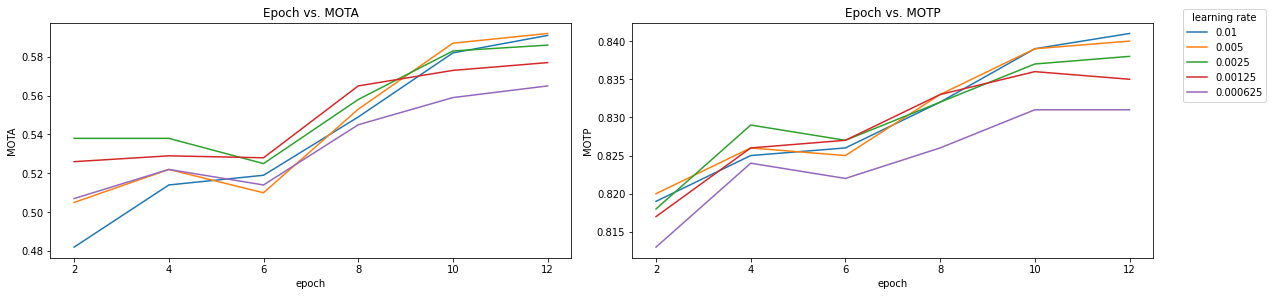

In [2]:
create_line_plots(data=val_df, x_axis='epoch', metrics=['MOTA', 'MOTP'], ncols=2, figsize=(16,4))

Multiple Object Tracking Accuracy (MOTA) measures the overall accuracy of both the tracker and detection. It accounts for all object configuration errors made by the tracker, false positives, misses, mismatches, over all of the frames, and gives a very intuitive measure of the tracker’s performance at keeping accurate trajectories, independent of its precision in estimating objects positions’. For most of the data, as the learning rate was increased, the tracking accuracy also decreased, with the exception of .005, where by the 12th epoch, it was obtaining a better accuracy than .01. This leads us to believe that with continued training we may have achieved better accuracies, but computation time was a huge limiting factor.

Multiple Object Tracking Precision (MOTP) is the average dissimilarity between all true positives and their corresponding ground truth targets. It gives the average overlap between all correctly matched hypotheses and their respective objects and ranges. Basically, it shows the ability of the tracker to estimate precise object positions, independent of the tracker’s skill at estimating the objects position, orientation, velocity, etc. As can be seen in the figure, as the learning rate is decreased, the tracking precision also decreases. Because of this, a learning rate of .01 yielded the best results. As with MOTA, here it only looks like the three largest learning rates are still increasing their accuracies at a decent rate per epoch, so we again think that with more epochs we can achieve a better accuracy.


<h1 align="center">False Negative and False Positive Plots</h1> 

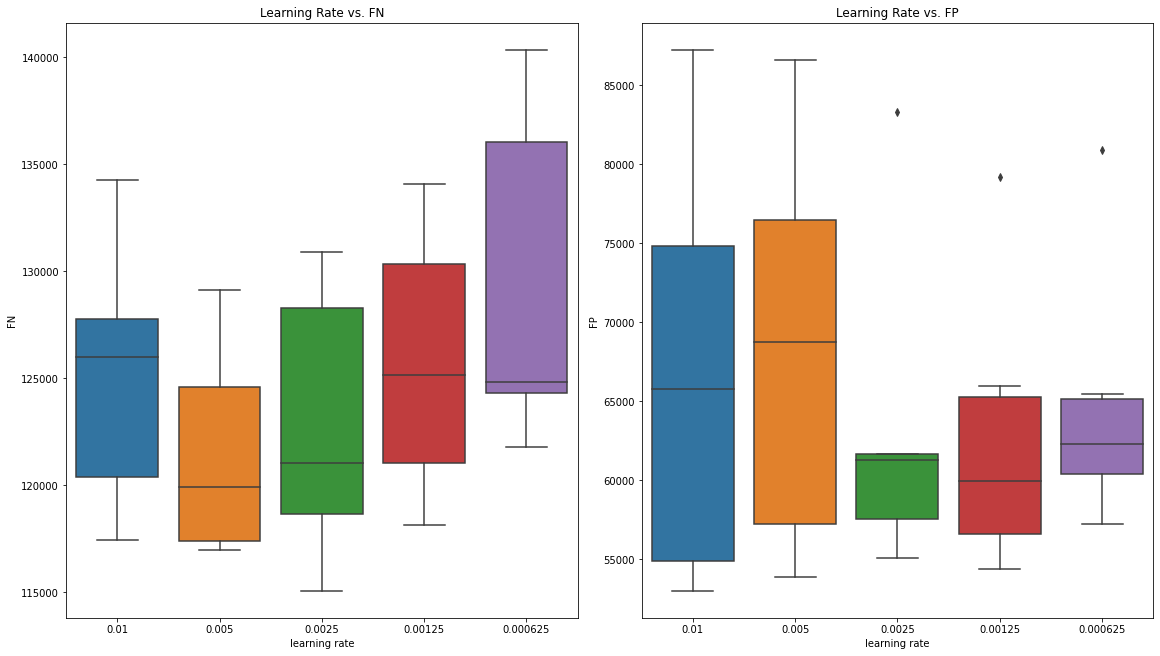

In [4]:
x_axis = 'learning_rate'
create_box_plots(data=val_df, x_axis=x_axis, metrics=['FN','FP'], ncols=2, figsize=(16,9))

## FN and FP
As you can see above a learning rate of 0.005 minimized false negatives while simultaneously also having the largest amount of false positives. But since we want to minimize collisions with cars and also collisions with other people on the road. We believe that recall is a much better metric in this case. And since .005 also leads in that metric with 0.73. Then it is probably a better learning rate with this data for the purpose of not missing important information in the road.

One thing to note is that the amount of false positives is half the number of false negatives so since we are using absolute numbers and not rates. False negatives are better to pay attention to because the same looking difference in the graphs is actually twice as large for FN just because it's y axis is set around 120,000 values while it is around 70,000 for FP 

<h1 align="center">Recall and Precision Plots</h1> 

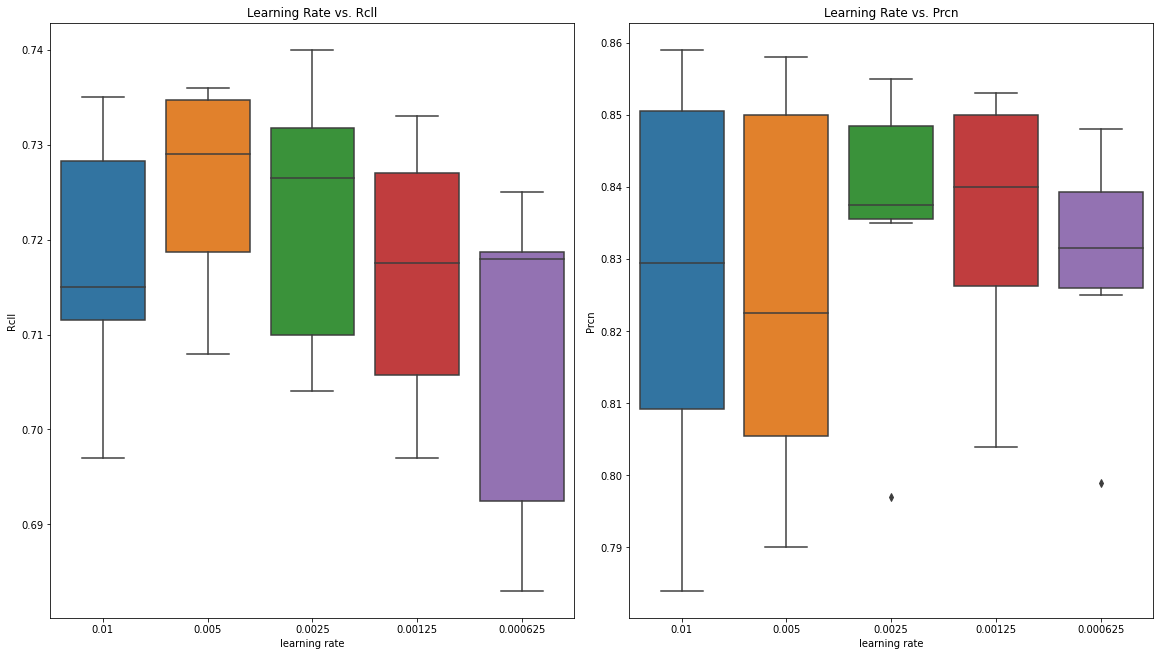

In [5]:
x_axis = 'learning_rate'
create_box_plots(data=val_df, x_axis=x_axis, metrics=['Rcll','Prcn'], ncols=2, figsize=(16,9))

## Recall and Precision Analysis

Recall is the left most graph and it peaks in the 0.005 learning rate and then goes down when learning rate is either increased or decreased. From the analysis from before we believe that Recall is most important because we want to avoid false negatives and not seeing other cars/pedestrians. But in the long terms the values of both precision and recall are really all within a couple percent but across the 40,000 validation images that does come up to a significant number. And in the case of maximizing recall, it may even save lives.

<h1 align="center">MT PT ML FM Plots</h1> 

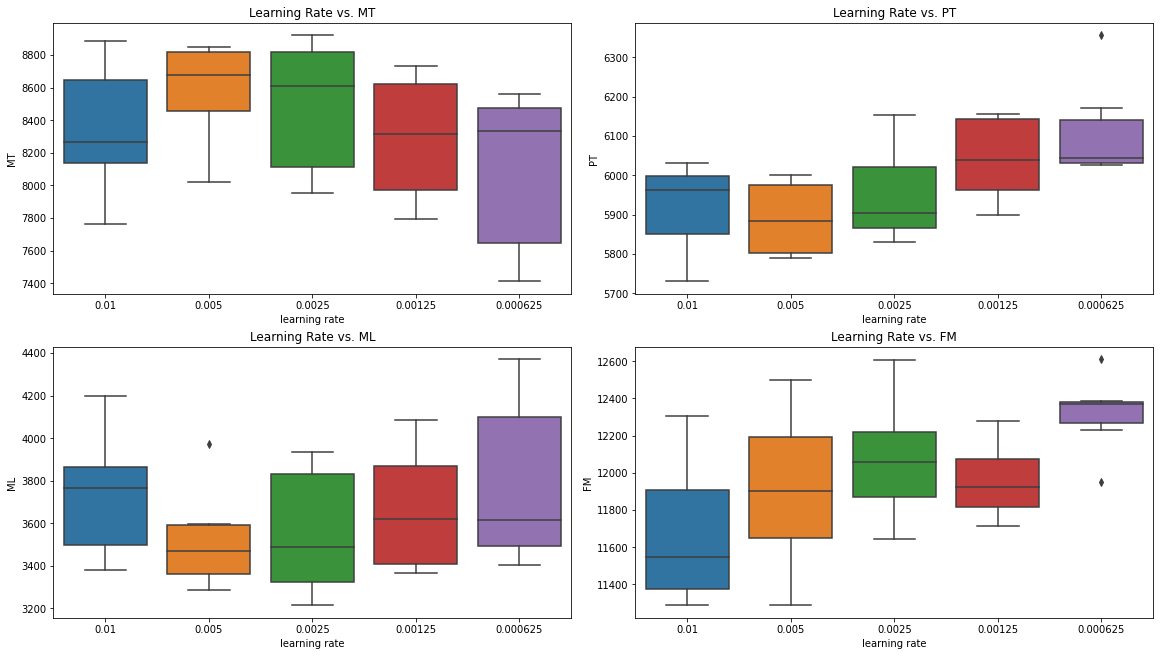

In [6]:
x_axis = 'learning_rate'
create_box_plots(data=val_df, x_axis=x_axis, metrics=['MT','PT','ML','FM'], ncols=2, figsize=(16,9))

### From above we can look at each plot separately and describe each metric and how each learning rate affected our results. 

## MT 
MT stands for mostly tracked and it means that at least 80 percent of the lifespan of the vehicle was tracked. This was led by a learning rate of 0.005 and shows that once it identified an object it didn't seem to lose track of it and was not prone to suddenly losing track of something. We want to maximize these and hypothetically having everything in the MT category would be the ideal goal since that means our network kept track of everything at all times.

## PT
PT looks at objects that were tracked between 20 to 80% of their lifespan, and stands for partially tracked. While looking at the PT graph, the learning rate of 0.005 was the worst compared to the rest of the learning rates. This makes sense due to it tracking more objects in MT. But the metric itself is way too vast to be meaningful since if the average for most tracked objects was around 30% then that means almost 2/3 of the time, something was not seen. While another learning rate could have an average of 60% of their lifespan but have a lower PT score which is why the gap from 20 to 80% seems too big and meaningless.

## ML
ML stands for mostly lost, and includes everything else we have not covered above. Which means everything tracked for less than 20% of its lifespan. And here most learning rates really hovered around the same sort of number except for .01 which was a good amount higher than the rest. But for real life applications, tracking something for less than 20% of its life is mostly meaningless, but still provides a glimmer that maybe with more training or optimizations those are all possible objects that can hopefully be detected with more work.

## FM
FM as a metric is Number of fragmentations where it is the number of times something switched from being tracked to not being tracked. Here .01 performed the best and .000625 was the worst. This means that a far lower learning rate made the network have less experience with tracking and that it probably did not have enough confidence to know how vehicles move.

<h1 align="center">IDF1 Score</h1> 

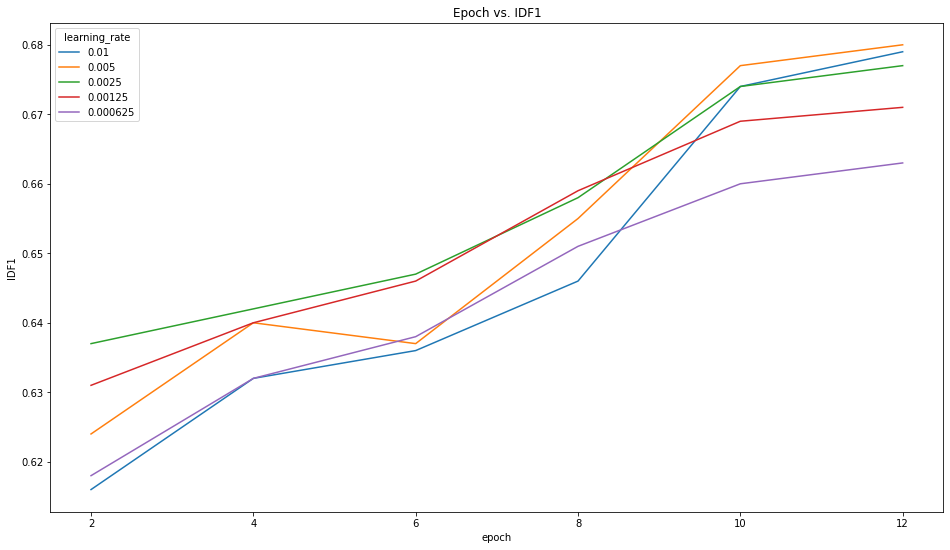

In [7]:
plt.figure(figsize = (16,9))
ax = sns.lineplot(x='epoch', y='IDF1', hue='learning_rate', data=val_df)
plt.title('Epoch vs. IDF1')
plt.show()

As we mentioned before, errors from false negatives are more undesireable because we want to minimize collisions with obstacles and a learning rate of 0.005 minimized false negatives. As you can see from the plot above, a learning rate of 0.005 yields the highest IDF1 score. The IDF1 score is the ratio of correctly identified detections over the average number of ground-truth and computed detections. This shows how a learning rate of 0.005 performs better when both false negatives and false positives are undesireable. 

# Discussion

### Interpreting the result

From our results, we can see that a learning rate of 0.005 maximized the metrics of MOTA, recall, MT, and IDF1. A learning rate of 0.01 performed better in the metrics of MOTP and FM. Our lowest learning rate of 0.000625 performed the worst in many metrics like MOTA, MOTP, recall, MT and FM. With our goal of minimizing the number of false negatives, which are obstacles that our model couldn't detect, the learning rate of 0.005 performs much better than the other learning rates. Although a learning rate of 0.01 performed better in MOTP and FM, precision and number of switches in tracking doesn't have the same cost as false negatives. Like we mentioned in our results, false positives aren't valued the same because that the model just identifies a non-existant obstacle. This might have some problems in autonomous driving like forcing the car to take a weird route, but isn't as bad as not detecting an object and crashing into it. 

### Limitations

One limitation was how computationally expensive it was to train our models. Given that we were working with object tracking, we needed a large set of data to be able to get meaningful results from our model. However, this meant that it would take days for us to be able to retrain our models after making any changes. This slowed down our process due to the amount of time it took to impliment new changes. Another limitation was the amount of epochs we used. During analysis, we noticed that some of our learning rates had not fully plateaued by the 12th epoch, meaning that they could have possibly performed better, given that there were more epochs for them to learn with. 

### Ethics & Privacy

For ethics and privacy, we are using a dataset of drivable environments that an autonomous vehicle would see, in it we will be encountering other cars, pedestrians, street signs, bikes and buildings. One privacy concern is that it will obviously have the faces and appearances of people around where the driving data was taken, but we are not specifically doing facial recognition and we will not make out who or what the person looks like crossing the road. All we’ll be doing is seeing if it is a person or not, therefore ignoring the individual identity of the person. Considering we keep our code hidden and only have a trained model, people will also not be able to identify pedestrians’ faces unless they themselves go and do it but considering how hard it is to identify faces from our dataset, we do not believe it is of much concern.

Also ethically, our solution could make mistakes and mislabel a pedestrian crossing a street as a lightpost or a stationary object or not even see it and accidently hit it. We can only address these issues by making sure that our model does not make many of these mistakes. But these are extremely rare and just our solution would not be used in guiding an autonomous vehicle. Autonomous vehicles usually come equipped with LIDAR/RADAR and have a pipeline of image processing to make sure it does not make mistakes in labeling people. So there will be many redundancies in case we mislabel a pedestrian.

### Conclusion

From our analysis, we found that a learning rate of 0.00625 had the worst metric scores for important metrics such as precision, accuracy, mostly tracked, and IDF1. This is likely due to the fact that since the learning rate was so low, it wasn't able to update the model quickly enough in order to learn across epochs. On the other hand, our analysis showed that a learning rate of 0.005 performs the best in many of the metrics such as MOTA, recall, MT and IDF1. In each of these, after the 6th epoch, the model begins to learn much more and quickly improves its metric scores. These results are likely due to the fact that at a high learning rate, such as 0.01, the model is most likely overshooting and causing unstable training, and at low rates such as 0.00625 the model isn't being updated our enough, causing a failure to train. Given this insight, we would be able to tune our model to maximize our metric scores and lead to a better tracking output. We would be maximizing our true positives and true negatives, while minimizing our false negatives, which are very undesirable in multiple object detection for autonomous driving, given that false negative could lead to a vehicle hitting another vehicle, or even a pedestrian. This work could be applied to other problems that require multiple object detection like delivery robots that deliver food and groceries to people or even drones that use onject tracking to to record videos. In the future, we would like to explore more hyper parameters for this complex model and test on larger datasets to see what issues may arise and work to see how we can tune our model to account for them and still produce valuable outputs. 


### Extra Credit

We think we earned extra credit due to the sheer size of our project and how much effort it took to even get to a baseline level of using it. Multi-Object Tracking was confusing at first and forced us to work with a lot of metrics we have never heard of to quantify performance and we think we did a good job at looking at all the code and keeping all the moving parts in mind to modify on what subsets we could perform training and how we could modify the length of the training process. We did not have much room for error due to training taking close to two days for just one learning rate, and that's with 2 RTX 2080's in a dual set up. 

Along with that we think 

# Footnotes
<a name="posenote"></a>1.[^](#pose): M. Voit, K. Nickel, and R. Stiefelhagen, “Multi-view head pose estimation using neural networks,” in Proceedings of the 2nd Workshop on Face Processing in Video (FPiV ’05), in association with the 2nd IEEE Canadian Conference on Computer and Robot Vision (CRV ’05), pp. 347–352, Victoria, Canada, May 2005. https://doi.org/10.1007/978-3-540-69568-4_26 <br>
<a name="motanote"></a>2.[^](#mota): Bernardin. (2008) Evaluating Multiple Object Tracking Performance: The CLEAR MOT Metrics. https://link.springer.com/article/10.1155/2008/246309 <br>
<a name="motnote"></a>3.[^](#mot):Luo, Wenhan, et al. "Multiple object tracking: A literature review." Artificial Intelligence 293 (2021): 103448. https://arxiv.org/abs/1409.7618<br>
<a name="deftnote"></a>4.[^](#deft): Chaabane, Mohamed, et al. "Deft: Detection embeddings for tracking." arXiv preprint arXiv:2102.02267 (2021). https://arxiv.org/abs/2102.02267<br>
<a name="centernetnote"></a>5.[^](#centernet): Zhou, Xingyi, Dequan Wang, and Philipp Krähenbühl. "Objects as points." arXiv preprint arXiv:1904.07850 (2019). https://arxiv.org/abs/1904.07850<br>
<a name="affinitynote"></a>6.[^](#affinity): Sun, ShiJie, et al. "Deep affinity network for multiple object tracking." IEEE transactions on pattern analysis and machine intelligence 43.1 (2019): 104-119. https://arxiv.org/abs/1810.11780<br>
<a name="lstmnote"></a>7.[^](#lstm): Sadeghian, Amir, Alexandre Alahi, and Silvio Savarese. "Tracking the untrackable: Learning to track multiple cues with long-term dependencies." Proceedings of the IEEE international conference on computer vision. 2017. https://arxiv.org/abs/1701.01909<br>
<a name="quasinote"></a>8.[^](#quasi): Pang, Jiangmiao, et al. "Quasi-dense similarity learning for multiple object tracking." Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2021. https://arxiv.org/abs/2006.06664<br>
<a name="siamesenote"></a>9.[^](#siamese): He, Anfeng, et al. "A twofold siamese network for real-time object tracking." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018. https://arxiv.org/abs/1802.08817v1<br>

# Appendix

## CUDA Driver, CUDA+PyTorch Support

### How to make CUDA 11.3 work with mmcv-full/pytorch on a Windows machine:
- Set up WSL2 on your machine first in powershell(may need admin powershell)
`wsl --install`
    - Make sure you have WSL2 installed and not WSL1
`wsl -l -v.`
- Go into the microsoft store and download Ubuntu 22.04
- Install conda on Ubuntu 22.04
- Create conda environment with python version 3.8
`conda create -n qdtrack python=3.8 -y`
- Install CUDA 11.3 via the WSL instructions
    - Recommend doing this in /tmp/ or create a temp folder like `/install/` before running this

- Install pytorch 1.11 that’s compatible with cuda 11.3
`conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch`
- Test if cuda is available
`python 
import torch
print(torch.cuda.is_available())`
and hopefully returns true


- Install mmcv-full 1.4.7 that’s compatible with cuda 11.3
`pip install mmcv-full==1.4.7 -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html`
- Install the latest version of mmdet(using 2.24.1)
`pip install mmdet`
- Install qdtrack from the qdtrack git repository
`python setup.py develop`
- Install other packages needed from the requirements.txt just in case
`pip install lvis motmetrics pycocotools seaborn`


## Required Packages and Tools Downloading Instruction

- Download gcc on windows: https://dev.to/gamegods3/how-to-install-gcc-in-windows-10-the-easier-way-422j 
- Compatible versions for this project: mmcv==1.3.17 and mmdet==2.24.1